In [18]:
# 1(a)
import numpy as np
import matplotlib.pyplot as plt

def linear_congruential_generator(seed, a=1664525, c=1013904223, m=2**32):
    seed = (a * seed + c) % m
    # 確保生成的隨機數不會是 0
    random_number = seed / m
    if random_number == 0:
        random_number = 1 / m  # 最小值設定為極小數
    return random_number, seed

# 生成標準正態近似分佈的數據
def generate_standard_normal_via_clt_lcg(seed):
    sum_uniform = 0
    # 生成12個均勻隨機數
    for _ in range(12):
        uniform_value, seed = linear_congruential_generator(seed)
        sum_uniform += uniform_value
    # 回傳近似標準正態分佈數據以及新種子
    return sum_uniform - 6, seed

# 單變量高斯（正態）分佈生成器
def generate_univariate_gaussian(mean, variance, seed):
    # 先生成標準正態分佈的數據
    standard_normal_value, seed = generate_standard_normal_via_clt_lcg(seed)
    # 根據給定的期望值和變異數進行變換
    gaussian_value = mean + np.sqrt(variance) * standard_normal_value
    return gaussian_value, seed

# 初始種子
seed = 123456789
# 設定高斯分佈的均值和變異數
mean, variance = 5, 10
# 生成單變量高斯分佈的隨機數
random_value, new_seed = generate_univariate_gaussian(mean, variance, seed)
print(f"Random Gaussian Value: {random_value}, New Seed: {new_seed}")


Random Gaussian Value: 1.6311946397332742, New Seed: 1218163169


In [9]:
# 1(b)
import numpy as np

# Box-Muller 方法來生成正態分布的噪聲
def box_muller_transform(u1, u2):
    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2 * np.pi * u2)
    return z0

# 多項式基底線性模型
def polynomial_basis_linear_model(n, a, w, seed):
    # 使用 LCG 生成均勻分布的 x，範圍為 (0, 1)
    rand_val, seed = linear_congruential_generator(seed)
    x = 2 * rand_val - 1  # 將 (0, 1) 的隨機數轉換為 (-1, 1)
    
    # 生成基底函數 phi(x)
    phi_x = np.array([x**i for i in range(n)])
    
    # 使用 LCG 生成兩個均勻分布的隨機數，來使用 Box-Muller 生成正態分布的噪聲
    u1, seed = linear_congruential_generator(seed)
    u2, seed = linear_congruential_generator(seed)
    e = a * box_muller_transform(u1, u2)  # 噪聲 e 服從 N(0, a)
    
    # 計算 y = W^T * phi(x) + e
    W = np.array(w)  # 將 w 調整為 n x 1 的向量
    y = np.dot(W.T, phi_x) + e
    
    return x, y, seed


In [11]:
#2. Sequential estimator to estimate mean and variance

def sequential_estimator(mean, variance, iterations, seed):
    current_mean = 0
    current_variance = 0
    for i in range(1, iterations + 1):
        new_data_point, seed = generate_univariate_gaussian(mean, variance, seed)
        
        # 更新均值
        previous_mean = current_mean
        current_mean = previous_mean + (new_data_point - previous_mean) / i
        
        # 更新變異數 (Welford's algorithm)
        if i > 1:
            current_variance = ((i - 2) / (i - 1)) * current_variance + ((new_data_point - previous_mean) ** 2) / i

        # 調整輸出格式
        print(f"Add data point: {new_data_point:.13f}")
        print(f"Mean = {current_mean:.13f}\tVariance = {current_variance:.13f}")
    
    return current_mean, current_variance

# 使用1(a)中的生成器，執行序列估計
seed = 123456789
mean, variance = 3, 5  # 目標高斯分佈的真實均值與變異數
iterations = 5 

# 執行估計
sequential_estimator(mean, variance, iterations, seed)

Add data point: 0.6178948852578
Mean = 0.6178948852578	Variance = 0.0000000000000
Add data point: 5.3882333204536
Mean = 3.0030641028557	Variance = 11.3780643931531
Add data point: 2.5751579342280
Mean = 2.8604287133131	Variance = 5.7500667596264
Add data point: 2.1743537989094
Mean = 2.6889099847122	Variance = 3.9510525367945
Add data point: 3.4863822051011
Mean = 2.8484044287900	Variance = 3.0904817910543


(2.8484044287899755, 3.0904817910542586)

In [13]:
import numpy as np

def multiply(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    
    # Ensure inputs are numpy arrays
    if not isinstance(A, np.ndarray) or not isinstance(B, np.ndarray):
        raise ValueError("Inputs must be of type numpy.ndarray")
    
    # Reshape A and B to ensure they are at least 2D
    A = A.reshape(-1, 1) if A.ndim == 1 else A
    B = B.reshape(-1, 1) if B.ndim == 1 else B

    # Get dimensions of the matrices
    rows_A, cols_A = A.shape
    rows_B, cols_B = B.shape
    
    # Ensure the number of columns in A is equal to the number of rows in B
    if cols_A != rows_B:
        raise ValueError("Number of columns in A must be equal to the number of rows in B")
    
    # Initialize the result matrix with zeros
    result = np.zeros((rows_A, cols_B))
    
    # Perform matrix multiplication
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i, j] += A[i, k] * B[k, j]
    
    return result

#matrix inverse
def inverse(A):
    n = len(A)
    # Initialize the augmented matrix manually with the identity matrix
    augmented_matrix = np.zeros((n, 2 * n))
    
    # Fill in the augmented matrix with A on the left and identity on the right
    for i in range(n):
        for j in range(n):
            augmented_matrix[i][j] = A[i][j]
        augmented_matrix[i][i + n] = 1.0  # Identity matrix portion
    
    # Perform row operations to turn A into the identity matrix
    for i in range(n):
        # Pivot: make the diagonal element 1
        if augmented_matrix[i][i] == 0:
            raise ValueError("Matrix is singular and cannot be inverted.")
        augmented_matrix[i] = augmented_matrix[i] / augmented_matrix[i][i]
        
        # Make the other elements in the current column 0
        for j in range(n):
            if i != j:
                augmented_matrix[j] = augmented_matrix[j] - augmented_matrix[j][i] * augmented_matrix[i]
    
    # Extract the right part of the augmented matrix as the inverse
    inverse_matrix = augmented_matrix[:, n:]
    return inverse_matrix


def identity_matrix(size):
    # Create an n x n matrix initialized with zeros
    identity_matrix = np.zeros((size, size))
    
    # Set the diagonal elements to the scalar value
    for i in range(size):
        identity_matrix[i, i] = 1
    
    return identity_matrix

def get_minor(matrix, i, j):
    """獲取刪除第 i 行和第 j 列後的子矩陣"""
    return np.delete(np.delete(matrix, i, axis=0), j, axis=1)

def determinant(matrix):
    """遞歸計算行列式"""
    n = matrix.shape[0]
    
    # 基本情況：當矩陣為 1x1 時，返回該元素
    if n == 1:
        return matrix[0, 0]
    
    # 遞歸展開
    det = 0
    for col in range(n):
        cofactor = (-1) ** col * matrix[0, col] * determinant(get_minor(matrix, 0, col))
        det += cofactor
    return det


In [100]:
#4. Baysian Linear regression


seed = 42  # 初始化種子

b, n, a, w = 1, 4, 1, [1, 2, 3, 4]

mu = np.array([0, 0, 0, 0]).reshape(-1, 1)
Sigma = 1/b * identity_matrix(n)
x_set = []
y_set = []
mu_set = []
Sigma_set = []

# 設定停止條件的誤差閾值
threshold = 1e-1  
error = 1  # 初始error

while(error>threshold):
    error = np.linalg.norm(mu_post.flatten() - np.array(w))
    x, y, new_seed = polynomial_basis_linear_model(n, a, w, seed) 

    # 構建設計矩陣 X (根據多項式基底)
    X = np.array([x**i for i in range(n)]).reshape(-1, 1).T

    # 更新後驗分佈
    Sigma_post = inverse(inverse(Sigma) + 1/a * multiply(X.T,X))
    mu_post = multiply(Sigma_post, multiply(inverse(Sigma), mu) + 1/a * X.T *y)

    # 預測分佈的均值和方差
    predictive_mean = multiply(X, mu_post)[0][0]
    predictive_variance = a + multiply(X, multiply(Sigma_post, X.T))[0][0]
    
    x_set.append(x)
    y_set.append(y)
    mu_set.append(mu)
    Sigma_set.append(Sigma)

    #更新參數
    seed = new_seed
    Sigma = Sigma_post
    mu = mu_post

    
    if i % 1000 == 0:
        # 輸出目前的後驗與預測分佈
        print("Postirior mean:") 
        print(mu_post)
        print("Posterior variance:")
        print(Sigma_post)
        print(f"Predictive distribution ~ N({predictive_mean}, {predictive_variance})")
        print()
    i += 1

Postirior mean:
[[1.02995839]
 [1.76133842]
 [3.03680139]
 [4.3711329 ]]
Posterior variance:
[[ 0.00344308 -0.00034336 -0.00582998  0.00084912]
 [-0.00034336  0.02581388  0.0018485  -0.03647223]
 [-0.00582998  0.0018485   0.01747658 -0.00421463]
 [ 0.00084912 -0.03647223 -0.00421463  0.06224724]]
Predictive distribution ~ N(0.768251403727064, 1.0040057930464952)

Postirior mean:
[[1.0228551 ]
 [1.78242013]
 [3.01592806]
 [4.37265712]]
Posterior variance:
[[ 0.00137376 -0.00011557 -0.00228356  0.00020493]
 [-0.00011557  0.01083088  0.00030057 -0.01513406]
 [-0.00228356  0.00030057  0.0067339  -0.0006878 ]
 [ 0.00020493 -0.01513406 -0.0006878   0.02526114]]
Predictive distribution ~ N(5.328057244064217, 1.0017291647466602)

Postirior mean:
[[1.04051579]
 [1.93956126]
 [2.9842769 ]
 [4.11556285]]
Posterior variance:
[[ 8.50387919e-04 -6.48401660e-05 -1.42429689e-03  1.01462179e-04]
 [-6.48401660e-05  6.85448585e-03  1.52736943e-04 -9.62960135e-03]
 [-1.42429689e-03  1.52736943e-04  4.2633

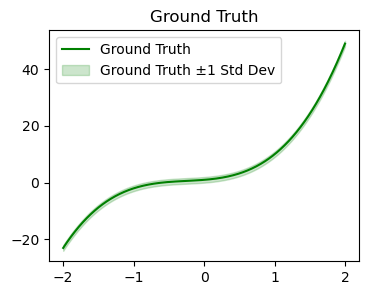

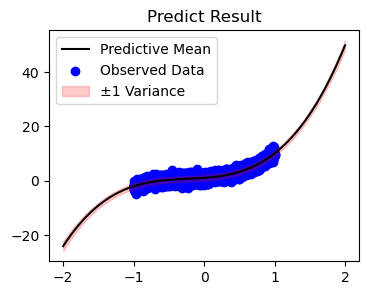

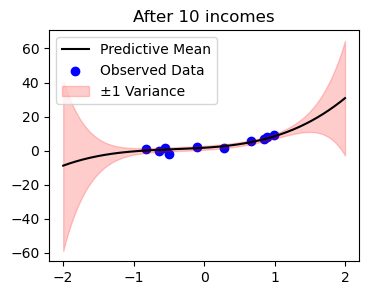

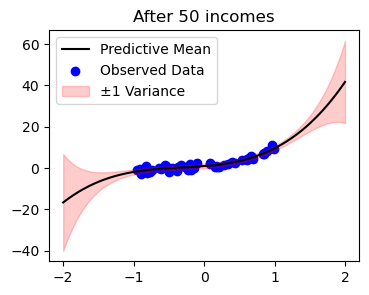

In [66]:
# 繪製結果
def plot_results(x_points, y_points, mu_set, Sigma_set, ground_truth_weights, noise_variance):

    x_range = np.linspace(-2, 2, 500)
    
    # Plot Ground Truth
    y_ground_truth = np.polyval(ground_truth_weights[::-1], x_range)  # 計算 Ground Truth 曲線
    
    # Ground Truth 的標準差（與觀測噪聲相關）
    ground_truth_std = np.sqrt(noise_variance)
    
    plt.figure(figsize=(4, 3))
    plt.plot(x_range, y_ground_truth, 'g-', label="Ground Truth")
    plt.fill_between(
        x_range,
        y_ground_truth - ground_truth_std,
        y_ground_truth + ground_truth_std,
        color='g',
        alpha=0.2,
        label="Ground Truth ±1 Std Dev"
    )
  
    plt.title("Ground Truth")
    plt.legend()
    plt.show()

    # Plot Predict
    # 繪製模型的預測均值和方差
    X_range = np.array([[x**i for i in range(n)] for x in x_range])  # 設計矩陣
    predictive_mean = X_range @ mu_set[-1]  # 最終迭代的預測均值
    predictive_variance = np.array([a + X_range[i] @ Sigma_set[-1] @ X_range[i].T for i in range(len(x_range))])
    plt.figure(figsize=(4, 3))
    plt.scatter(x_points, y_points, c='b', label="Observed Data")
    plt.plot(x_range, predictive_mean, 'k-', label="Predictive Mean")
    plt.fill_between(
        x_range,
        predictive_mean.flatten() - predictive_variance,
        predictive_mean.flatten() + predictive_variance,
        color='r',
        alpha=0.2,
        label="±1 Variance"
    )
        
    plt.title("Predict Result")
    plt.legend()
    plt.show()

    # Plot 10 incomes and 50 incomes
    for iteration in range(100):
        if iteration == 10 or iteration == 50:
            plt.figure(figsize=(4, 3))
            # 繪製模型的預測均值和方差
            X_range = np.array([[x**i for i in range(n)] for x in x_range])  # 設計矩陣
            predictive_mean = X_range @ mu_set[iteration]  # 最終迭代的預測均值
            predictive_variance = np.array([a + X_range[i] @ Sigma_set[iteration] @ X_range[i].T for i in range(len(x_range))])
            plt.scatter(x_points[:iteration], y_points[:iteration], c='b', label="Observed Data")
            plt.plot(x_range, predictive_mean, 'k-', label="Predictive Mean")
            plt.fill_between(
                x_range,
                predictive_mean.flatten() - predictive_variance,
                predictive_mean.flatten() + predictive_variance,
                color='r',
                alpha=0.2,
                label="±1 Variance"
            )
        
            plt.title(f"After {iteration} incomes")
            plt.legend()
            plt.show()
    
plot_results(x_set, y_set, mu_set, Sigma_set, w, b)